# Schelling's segregation model

Source: [`Agents.jl` tutorial](https://juliadynamics.github.io/Agents.jl/stable/tutorial/). [Wikipedia](https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation)

- Agents : They belong to one of two groups (0 or 1).
- Model : Each position of the grid can be occupied by at most one agent.
- For each step
  - If an agent has at least 3 neighbors belonging to the same group, then it is happy.
  - If an agent is unhappy, it keeps moving to new locations until it is happy.

To define an agent type, we should make a mutable struct derived from `AbstractAgent` with 2 mandatory fields:
- `id::Int` . The identifier number of the agent.
- `pos` . For agents on a 2D grid, the position field should be a tuple of 2 integers.

On top of that, we could define other properties for the agents.

## Setup

First, we create a 2D space with a Chebyshev metric. This leads to *8 neighboring positions* per position (except at the edges of the grid).

In [1]:
using Agents
using Random
using CairoMakie
CairoMakie.activate!(px_per_unit = 1.0)

The helper function below is adapted from `Agents.abmvideo` and correctly displays animations in Jupyter notebooks

In [2]:
function abmvio(model;
    dt = 1, framerate = 30, frames = 300, title = "", showstep = true,
    figure = (size = (600, 600),), axis = NamedTuple(),
    recordkwargs = (compression = 23, format ="mp4"), kwargs...
)
    # title and steps
    abmtime_obs = Observable(abmtime(model))
    if title ≠ "" && showstep
        t = lift(x -> title*", time = "*string(x), abmtime_obs)
    elseif showstep
        t = lift(x -> "time = "*string(x), abmtime_obs)
    else
        t = title
    end

    axis = (title = t, titlealign = :left, axis...)
    # First frame
    fig, ax, abmobs = abmplot(model; add_controls = false, warn_deprecation = false, figure, axis, kwargs...)
    resize_to_layout!(fig)
    # Animation
    Makie.Record(fig; framerate, recordkwargs...) do io
        for j in 1:frames-1
            recordframe!(io)
            Agents.step!(abmobs, dt)
            abmtime_obs[] = abmtime(model)
        end
        recordframe!(io)
    end
end

abmvio (generic function with 1 method)

Define the Agent type using the [`@agent`](https://juliadynamics.github.io/Agents.jl/stable/api/#Agents.@agent) macro.
The agents inherit all properties of `GridAgent{2}` sicne they live on a 2D grid. They also have two properties: `mood` (happy or not) and `group`.

In [3]:
@agent struct SchellingAgent(GridAgent{2})
    mood::Bool = false ## true = happy
    group::Int ## the group does not have a default value!
end

Define the stepping function for the agent `nearby_agents(agent, model)` lists neighbors.
If there are over 2 neighbors of the same group, make the agent happy.
Else,  the agent will move to a random empty position

In [4]:
function schelling_step!(agent::SchellingAgent, model)
    minhappy = model.min_to_be_happy
    count_neighbors_same_group = 0
    for neighbor in nearby_agents(agent, model)
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end
    if count_neighbors_same_group ≥ minhappy
        agent.mood = true ## The agent is happy
    else
        agent.mood = false
        move_agent_single!(agent, model) ## Move the agent to a random position
    end
    return nothing
end

schelling_step! (generic function with 1 method)

It is recommended to use a function to create the ABM for easily alter its parameters.

In [5]:
function init_schelling(; numagents = 300, griddims = (20, 20), min_to_be_happy = 3, seed = 2024)
    # Create a space for the agents to reside
    space = GridSpace(griddims)
    # Define parameters of the ABM
    properties = Dict(:min_to_be_happy => min_to_be_happy)
    rng = Random.Xoshiro(seed)
    # Create the model
    model = StandardABM(
        SchellingAgent, space;
        properties, rng,
        agent_step! = schelling_step!,
        container = Vector, ## agents are not removed, this is faster
        scheduler = Schedulers.Randomly()
    )

    # Populate the model with agents, adding equal amount of the two types of agents at random positions in the model.
    # We don't have to set the starting position. Agents.jl will choose a random position.
    for n in 1:numagents
        add_agent_single!(model; group = n < 300 / 2 ? 1 : 2)
    end
    return model
end

init_schelling (generic function with 1 method)

## Running the model

In [6]:
model = init_schelling()

StandardABM with 300 agents of type SchellingAgent
 agents container: Vector
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

The `step!()` function evolves the model forward. The `run!()` function is similar to `step!()` but also collects data along the simulation.
Progress the model by one step.

In [7]:
step!(model)

StandardABM with 300 agents of type SchellingAgent
 agents container: Vector
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

Progress the model by 3 steps

In [8]:
step!(model, 3)

StandardABM with 300 agents of type SchellingAgent
 agents container: Vector
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

Progress the model until 90% of the agents are happy

In [9]:
happy90(model, time) = count(a -> a.mood == true, allagents(model))/nagents(model) ≥ 0.9
step!(model, happy90)

StandardABM with 300 agents of type SchellingAgent
 agents container: Vector
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

How many steps are passed

In [10]:
abmtime(model)

4

## Visualization
The `abmplot()` function visulizes the simulation result using Makie.jl.
Some helper functions to identify agent groups.

In [11]:
groupcolor(a) = a.group == 1 ? :blue : :orange
groupmarker(a) = a.group == 1 ? :circle : :rect

groupmarker (generic function with 1 method)

Plot the initial conditions of the model

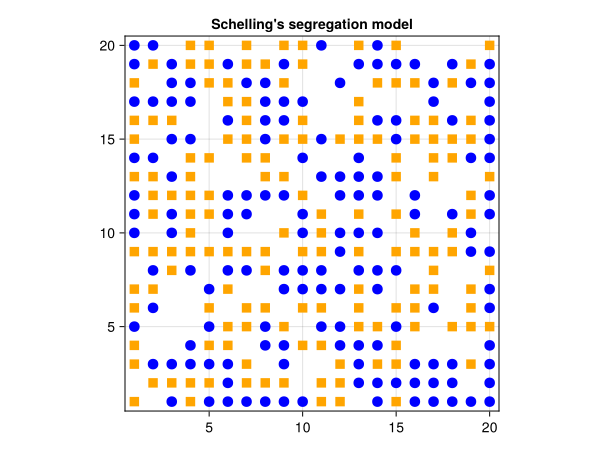

In [12]:
model = init_schelling()
figure, _ = abmplot(model; agent_color = groupcolor, agent_marker = groupmarker, agent_size = 15, axis=(;title = "Schelling's segregation model"))
figure

Let's make an animation for the model evolution.

In [13]:
model = init_schelling()
vio = abmvio(model;
    agent_color = groupcolor,
    agent_marker = groupmarker,
    agent_size = 15,
    framerate = 4, frames = 20,
    title = "Schelling's segregation model"
)

vio |> display

Makie.VideoStream(Base.PipeEndpoint(RawFD(22) open, 0 bytes waiting), Process(setenv(`/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 4 -pixel_format rgb24 -f rawvideo -s:v 600x600 -r 4 -i pipe:0 -vf vflip -profile:v high422 -crf 23 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_g182mz/##video#226.mp4'`,["JULIA_CI=true", "PATH=/home/runner/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/runner/.julia/artifacts/0ccc8805e5047cf9fbd848c4f7d4c15715aad7c9/bin:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/bin:/home/runner/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/runner/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/runner/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/runner/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/runner/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/runner/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/opt/hostedtoolcache/julia/1.10.6/x64/bin:/opt/hostedtoolcache/Python/3.12.7/x64/bin:/opt/hostedtoolcache/Python/3.12.7/x64:/snap/bin:/home/runner/.local/bin:/opt/pipx_bin:/home/runner/.cargo/bin:/home/runner/.config/composer/vendor/bin:/usr/local/.ghcup/bin:/home/runner/.dotnet/tools:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin", "DOTNET_SKIP_FIRST_TIME_EXPERIENCE=1", "GITHUB_RUN_NUMBER=449", "GITHUB_REF_NAME=main", "RUNNER_ARCH=X64", "STATS_PIP=false", "PERFLOG_LOCATION_SETTING=RUNNER_PERFLOG", "LD_LIBRARY_PATH=/home/runner/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/opt/hostedtoolcache/julia/1.10.6/x64/bin/../lib/julia:/home/runner/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/runner/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/runner/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/runner/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/runner/.julia/artifacts/0ccc8805e5047cf9fbd848c4f7d4c15715aad7c9/lib:/home/runner/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/runner/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/runner/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/runner/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/runner/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/runner/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/lib:/home/runner/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/runner/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/runner/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/runner/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/runner/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/runner/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/runner/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/runner/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/runner/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/runner/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/runner/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/runner/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/runner/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/runner/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/runner/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/runner/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/runner/.julia/artifacts/c8a2

## Data analysis
The `run!()` function runs simulation and collects data in the `DataFrame` format. The `adata` (aggregated data) keyword selects fields we want to extract in the DataFrame.

In [14]:
x(agent) = agent.pos[1]
adata = [x, :mood, :group]
model = init_schelling()
adf, mdf = run!(model, 5; adata)
adf[end-10:end, :] ## display only the last few rows

11×5 DataFrame
 Row │ time   id     x      mood  group 
     │ Int64  Int64  Int64  Bool  Int64 
─────┼──────────────────────────────────
   1 │     5    290      2  true      2
   2 │     5    291     14  true      2
   3 │     5    292      3  true      2
   4 │     5    293     16  true      2
   5 │     5    294     16  true      2
   6 │     5    295      2  true      2
   7 │     5    296     15  true      2
   8 │     5    297      7  true      2
   9 │     5    298     15  true      2
  10 │     5    299     11  true      2
  11 │     5    300      7  true      2

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*